# Dragon's Dogma II: Sentiment Analysis Overtime
I basically decided to do this analysis as a way to test the *transformers* package and investigate general sentiment around the game Dragon's Dogma II. For the latter, I had heard the game was well designed but was suffering from backlash surrounding its high base game price ($69.99 USD at time of writing) and downloadable content (DLC). I thought it would be a relatively simple question to investigate.

# Required Packages

In [18]:
# Import required packages
from atproto import Client
import pandas as pd
import langid
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt

## Using BlueSky
We're going to be using BlueSky social media posts for a few reasons. First, BlueSky posts are free and fairly easy to source with their API using Atproto. Second, it will enable us to use existing models trained on posts (tweets) from X (formerly known) since posts on BlueSky are very similar in format due to similarities in how both social media platforms.

## Retrieving the Data
The code below iterates through a couple variations of the name "Dragon's Dogma II" to cover multiple versions of the query. The data pulled includes:
* Author: The account username attached to the post (ending in '.bsky.social')
* Post text: The text in the post
* Creation Date: Date the post was created
* Tags: Any hashtags associated with the post (note: this will mostly be blank since hashtags were implemented on [February 28, 2024](https://bsky.app/profile/bsky.app/post/3kmjbfqrrbu2t)) 

In [26]:
# Set permutations of the game's name
games = ["Dragon's Dogma 2",
            "Dragon's Dogma II",
            "Dragons Dogma 2",
            "Dragons Dogma II"]

# Set up atproto client object
client = Client()
client.login('username', 'password')

# Initialize list that will hold entries (as list of lists)
records = []

# Loop over each permutation of the game's name
for game in games:

    # Manual limit on loops through search; no limit may cause code to crash from memory running out
    internal_limit = 50

    # Set first cursor to pagniate through query results
    cursor = "0"

    # Set limit counter
    limit_counter = 1

    # Iterate through loop to increment cursor, then grab post data
    while cursor and internal_limit > limit_counter:
        # Query to get search posts with atproto on Bluesky
        x = client.app.bsky.feed.search_posts(params={'q': game,
                                            'limit': 100,
                                            'cursor': cursor})

        # Iterate through post data
        for item in x['posts']:
            # Get items for new row
            current_record = item['record']

            # Get author, post body, tags, and post creation date
            author = item['author']['handle']
            post_text = current_record['text']
            tags = current_record['tags']
            creation_date = current_record['created_at']

            """ Add records if they contain at least one keyword
             (issue where some items didn't have the game name) """
            check_string = post_text.lower().strip("'").replace("ii", '2')

            # Only add a record if it contains the words making up the title "Dragon's Dogma 2"
            if all([word for word in ['dragons', 'dogma', '2'] if word in check_string]):

                new_record = [creation_date,
                            author,
                            post_text,
                            tags]


                records.append(new_record)

        # Bump counter for flipping through results
        limit_counter += 1
        cursor = str(int(cursor)+100)


# Build and export dataframe
df = pd.DataFrame(records,
                  columns= ['post_date',
                            'author',
                            'post_text',
                            'tags'])

# Save while dropping duplicate entries
df = df.loc[df.astype(str).drop_duplicates(subset=['post_date',
                                                    'author',
                                                    'post_text']).index]
df = df[df['post_text'].notna()]
df.to_csv('bsky_data.csv', index = False)

## Preparing Data
Before we can analyze our data, we need to make the following adjustments:
* **Convert the "post_date" variable into datetime objects**: This will allow us to plot changes in sentiment overtime (especially before and after DLC pricing was announced and after the release date)
* **Remove non-English posts**: Our sentiment model is only trained on English so we can only analyze posts in English.

In [30]:
# Import the data and display the first few rows
df = pd.read_csv('bsky_data.csv')
df = df[df['post_text'].notna()]
df.head()

,post_date,author,post_text,tags
0,2024-03-27T23:18:06.236Z,demikane.bsky.social,One of my pawns in Dragon's Dogma 2 called me ...,NaN
1,2024-03-27T23:10:44.001Z,bigtittyalchemy.biz,A lot of people are pissed off Dragon's Dogma ...,NaN
2,2024-03-27T23:08:41.425Z,fouroffivewits.com,Of all the bad faith criticism of Dragon's Dog...,NaN
3,2024-03-27T23:04:48.248Z,boardgamefeast.bsky.social,Dragon's Dogma 2 is the logical endpoint of re...,NaN
4,2024-03-27T23:00:56.189Z,princebeaco.bsky.social,100% agreed. Single player games should also n...,NaN


### Convert "post_date" to a datetime object
Converting to a datetime object is fairly simple since the timestamps are in ISO8601 format

In [31]:
df['post_date'] = pd.to_datetime(df['post_date'], format='ISO8601', utc=True)
df.head()

,post_date,author,post_text,tags
0,2024-03-27 23:18:06.236000+00:00,demikane.bsky.social,One of my pawns in Dragon's Dogma 2 called me ...,NaN
1,2024-03-27 23:10:44.001000+00:00,bigtittyalchemy.biz,A lot of people are pissed off Dragon's Dogma ...,NaN
2,2024-03-27 23:08:41.425000+00:00,fouroffivewits.com,Of all the bad faith criticism of Dragon's Dog...,NaN
3,2024-03-27 23:04:48.248000+00:00,boardgamefeast.bsky.social,Dragon's Dogma 2 is the logical endpoint of re...,NaN
4,2024-03-27 23:00:56.189000+00:00,princebeaco.bsky.social,100% agreed. Single player games should also n...,NaN


### Remove non-English Posts
Since our sentiment model only works with English posts, we're going to filter out non-English posts using the *langid* and it's language classification model. This works by analyzing a text and classifying it by which language it is in. Since it's a machine learning model, it's not a perfect or ideal solution compared to manually filtering this data, but I've decided to use it due to the volume of the data (nearly 11k posts).

In [32]:
# Run the texts of each post through the classifier model
lang_scores = df.apply(lambda x: langid.classify(x['post_text']), axis=1)

# Assign each component of the results to columns and print the new head of the dataframe
df['language'] = lang_scores.apply(lambda x: x[0])
df['lang_score'] = lang_scores.apply(lambda x: x[1])
print(df.head())

# Save dataframes (first with all languages, then with English only)
df.to_csv('bsky_data_lang.csv', index = False)

df_en = df[df['language'] == 'en']
df_en.to_csv('bsky_en.csv', index = False)

                         post_date                      author  \
0 2024-03-27 23:18:06.236000+00:00        demikane.bsky.social   
1 2024-03-27 23:10:44.001000+00:00         bigtittyalchemy.biz   
2 2024-03-27 23:08:41.425000+00:00          fouroffivewits.com   
3 2024-03-27 23:04:48.248000+00:00  boardgamefeast.bsky.social   
4 2024-03-27 23:00:56.189000+00:00     princebeaco.bsky.social   

                                           post_text tags language  lang_score  
0  One of my pawns in Dragon's Dogma 2 called me ...  NaN       en -240.358485  
1  A lot of people are pissed off Dragon's Dogma ...  NaN       en -646.969551  
2  Of all the bad faith criticism of Dragon's Dog...  NaN       en -495.657295  
3  Dragon's Dogma 2 is the logical endpoint of re...  NaN       en -107.413521  
4  100% agreed. Single player games should also n...  NaN       en -263.410423  


In [33]:
# Re-import the data with only the english data
df = pd.read_csv('bsky_en.csv')
df.head()

,post_date,author,post_text,tags,language,lang_score
0,2024-03-27 23:18:06.236000+00:00,demikane.bsky.social,One of my pawns in Dragon's Dogma 2 called me ...,NaN,en,-240.358485
1,2024-03-27 23:10:44.001000+00:00,bigtittyalchemy.biz,A lot of people are pissed off Dragon's Dogma ...,NaN,en,-646.969551
2,2024-03-27 23:08:41.425000+00:00,fouroffivewits.com,Of all the bad faith criticism of Dragon's Dog...,NaN,en,-495.657295
3,2024-03-27 23:04:48.248000+00:00,boardgamefeast.bsky.social,Dragon's Dogma 2 is the logical endpoint of re...,NaN,en,-107.413521
4,2024-03-27 23:00:56.189000+00:00,princebeaco.bsky.social,100% agreed. Single player games should also n...,NaN,en,-263.410423


## Quick EDA
Before proceeding, we'll create a graph that gives us an idea of how the data is distributed so far by year and month. This way, we'll see if there are any issues with how posts are distributed by date. This is because we should expect a strong left skew distribution in the number of posts towards the release of the game.

In [40]:
df_date = df.copy().sort_values('post_date', ascending=True)
df_date['post_date'] = pd.to_datetime(df_date['post_date'], format='ISO8601', utc=True)
df_date['year_month'] = df_date['post_date'].apply(lambda x: x.strftime('%Y-%m'))
df_date.head()

,post_date,author,post_text,tags,language,lang_score,year_month
2415,2023-05-24 20:44:31.405000+00:00,spearmint.bsky.social,dragon's dogma 2 real!!!!!!!!!!!!!!!!,NaN,en,-12.811050,2023-05
2414,2023-05-24 20:44:35.064000+00:00,aidanmoher.com,Dragon's Dogma 2 looking *sharp*.,NaN,en,2.724679,2023-05
2413,2023-05-24 20:45:03.444000+00:00,ivansayoray.bsky.social,Oh WOW! Dragon’s Dogma 2!,NaN,en,9.061840,2023-05
2563,2023-05-24 20:49:19.039000+00:00,isimon.bsky.social,Dragon's Dogma II,NaN,en,2.724679,2023-05
2412,2023-05-24 21:15:44.834000+00:00,aidanmoher.com,"Ehhhhhh. Metal Gear, Final Fantasy, Dragon's D...",NaN,en,-395.918580,2023-05


In [43]:
# Get counts of posts by month
df_date.groupby('year_month')['post_date'].count()

year_month
2023-05      15
2023-06       5
2023-07      12
2023-08      12
2023-09      94
2023-10      15
2023-11     140
2023-12      45
2024-01     167
2024-02     163
2024-03    2634
Name: post_date, dtype: int64

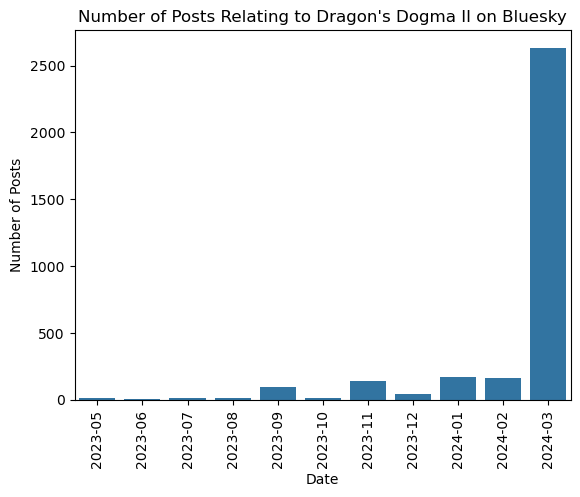

In [44]:
sns.countplot(df_date, x='year_month')
plt.title("Number of Posts Relating to Dragon's Dogma II on Bluesky")
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=90)
plt.show()

The post distribution is as expected. Most posts have been made in March 2024 which is when the game released, but there are a fair few from the months leading up to the release. This is likely due to news related to the release such as the [announcement of pricing for the game on November 29 2023](https://www.purexbox.com/news/2023/11/capcom-has-officially-raised-its-prices-with-the-arrival-of-dragons-dogma-2).

## Sentiment Model
Now that we have our data prepared, it's now time to run it through a sentiment model to determine the sentiment of each post. We'll be using the Twitter-roBERTa-base for our project since Twitter posts are quite similar in format to BlueSky posts. Therefore, the model is expected to perform reasonably well for this purpose.

Note that there are some limitations with using a model like this, since it may not be entirely accurate, especially with text where sentiment is mixed.

In [34]:
# Use transformers package to set up pipeline to use Twitter-roBERTa-base model
sentiment_pipeline = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Apply model to post_text
sentiment_scores = df.apply(lambda x: sentiment_pipeline(x['post_text']), axis=1)
print(sentiment_scores[:5])

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0    [{'label': 'negative', 'score': 0.648339748382...
1    [{'label': 'negative', 'score': 0.827004790306...
2    [{'label': 'negative', 'score': 0.928479790687...
3    [{'label': 'neutral', 'score': 0.5741391181945...
4    [{'label': 'positive', 'score': 0.459432810544...
dtype: object


In [45]:
# Apply sentiment data to data and save
sentiment_scores = sentiment_scores.apply(lambda x: x[0])

df['sentiment_label'] = sentiment_scores.apply(lambda x: x['label'])
df['sentiment_score'] = sentiment_scores.apply(lambda x: x['score'])
df.head(10)

df.to_csv('bsky_en.csv', index=False)

## Graphing Sentiment Data
First, we'll make a graph on month and year increments like we did with the counts in the test graph earlier. But this time, we'll be able to separate different counts by sentiment.

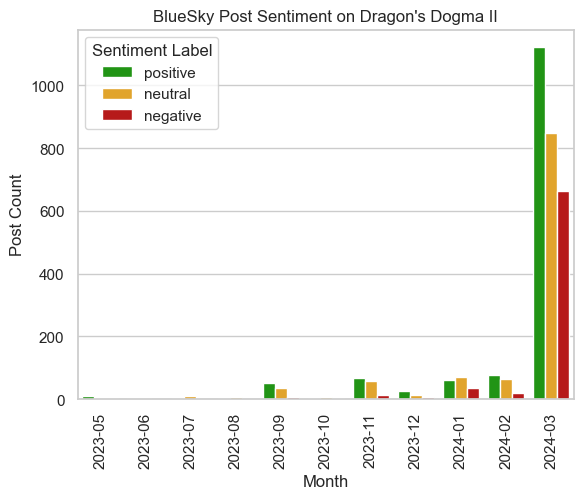

In [73]:
sns.set_theme(style='whitegrid')

g = sns.countplot(
    df_date,
    x='year_month',
    hue='sentiment_label',
    hue_order= ['positive','neutral','negative'],
    palette=["#10a900", "#ffae0e", "#d00000"]
)
plt.xlabel('Month')
plt.ylabel('Post Count')
plt.legend(title='Sentiment Label')
plt.xticks(rotation=90)
plt.title("BlueSky Post Sentiment on Dragon's Dogma II")
plt.show()

We see mostly positive and neutral sentiments in earlier months, but we also should separate the data out by before and after the release date since the game was released on March 22 2024. (Hence why most posts come from that month.)

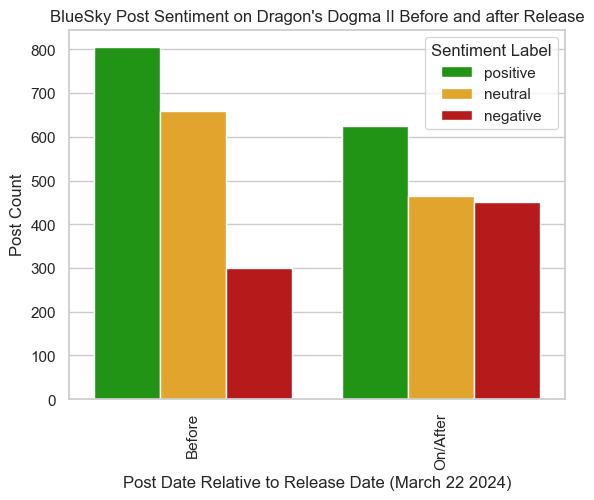

In [75]:
df_date['post_release'] = df_date['post_date'] >= '2024-03-22'

g = sns.countplot(
    df_date,
    x='post_release',
    hue='sentiment_label',
    hue_order= ['positive','neutral','negative'],
    palette=["#10a900", "#ffae0e", "#d00000"]
)
plt.xlabel('Post Date Relative to Release Date (March 22 2024)')
plt.ylabel('Post Count')
plt.legend(title='Sentiment Label')
plt.xticks(ticks=[False, True], labels=['Before','On/After'],rotation=90)
plt.title("BlueSky Post Sentiment on Dragon's Dogma II Before and after Release")
plt.show()

It appears that not only were there more posts on the game on and after release, there has also been a greater proportion of negative posts relative to positive and neutral ones. This suggests that the release has been controversial. There are a number of reasons that have likely contributed to this:
* The base game costs $69.99 (USD) on Steam, which some have criticized as too high, especially since this game does not have regional pricing. That is, this game costs the same even in regions where average purchasing power is lower than the US.
* The downloadable content (DLC) for this game has been criticized as [selling game functionality back to players](https://www.thegamer.com/dragons-dogma-2-microtransactions-dlc/) and as a potential strategy for raising game prices overtime.
* The game itself also has had mixed reviews on how it plays, especially in comparison to the original Dragon's Dogma.

## Limitations
To quantify how accurate the model was on this dataset would require manually checking at least a sample of the data, but on a cursory look, the model did seem relatively accurate in 80-90% of cases. However, this shows that these models are subject to error. Part of the source of this error is because this model is actually measuring the sentiment of the post itself, not relative to the topic we're trying to observe (the game). Additionally, the model can sometimes get the sentiment itself incorrect in the first place.

Here are a few examples of miscategorization that I found.

| post_date                        | author                 | post_text                                                                                                                                                                                                                                                                         | sentiment_label | sentiment_score   |
| -------------------------------- | ---------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------- | ----------------- |
| 2024-03-27 18:33:42.290000+00:00 | abrahmeden.bsky.social | Dragon's Dogma 2 is seventy bucks 🪦                                                                                                                                                                                                                                              | neutral         | 0.668060958385468 |
| 2024-03-27 15:53:57.821000+00:00 | mandydandy.bsky.social | being forced to participate in capitalism when i wanna play dragon's dogma 2... wah......                                                                                                                                                                                         | negative        | 0.816302537918091 |
| 2024-03-27 12:52:18.312000+00:00 | kelzor.bsky.social     | I think a lot of people jump to the conclusion that what they like about an experience like Dragon's Dogma 2 is "systemic" or "the friction" when in fact it's something much more vague: the "jank". Jank is a factor in video games that AAAs want to erase, and they're wrong. | negative        | 0.670968592166901 |

Notice how model doesn't categorize the first post correctly (perhaps because of the emoji?) and categorizes the second as negative because the post itself expresses a negative sentiment in general, not about the game. Lastly, the last post is relatively neutral but the text seems to use negative-ish language that probably confused the model.